<h1>Spot grid trading bot!!</h1>
<p>A Spot Grid Trading Bot is an automated tool that trades within a predefined price range to profit from market fluctuations. By dividing capital into smaller portions, the bot places buy and sell orders at regular intervals, creating a "grid" of trades. As prices move, the bot buys low and sells high, aiming to profit from the price differences. This strategy works well in sideways or slightly volatile markets, allowing traders to automate their strategies, reduce emotional decisions, and potentially generate consistent returns.</p>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import datetime as dt
plt.rc('figure',titleweight='bold',titlesize='large',figsize=(15,9))
plt.rc('axes',labelweight='bold',labelsize='large',titleweight='bold',titlesize='large',grid=True)
plt.rc('grid',color='red',alpha=0.5)

<script id=”MathJax-script” async src=”https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js”></script>
<h3>The 'spot_grid' class!</h3>
<p>There are 2 trading styles for spot grid bots. These are arithmetic and geometry, arithmetic is when the distance between the grids is a fixed number (eg : 100->110->120->130 ...) the grids are 10 units apart, and geometry is when The distance between the grids follows a certain ratio (eg: 100->110->121->133.1 ...) the rear grid is 1.1 times larger than the front grid.</p>
<ol>
    <li>
        <h3>The '__init__' function:</h3>
        Define some parameters:
        <ul>
            <li>'self.symbol' : what pair should be use for backtesting.</li>
            <li>'self.upper_limit' , 'lower_limit' : The trading range.</li>
            <li>'self.balance' : Initial balance of user.</li>
            <li>'self.amount' : The money spend for each order ( use to calcualate num_grids : number of grids ) .</li>
            <li>'self.buy_level' , 'self.sell_level' : To contain price levels so that when the price touches it, we will sell or buy.</li>
            <li>'self.coin_balance' : Record the amount of coin that was purchased at each price.</li>
            <li>'self.fee' : Denote the total fee of the whole testing periods.</li>
            <li>'self.current_level' : The current level of specific time.</li>
            <li>'self.start_date' , 'self.end_date' : The start and end date of the strategy.(can be None,if none,take the maximum start/end date available).</li>
            <li>'self.price' : Define which price used for stategy (usually close price).</li>
            <li>'self.profit' : Used to draw the profit curve.</li>
            <li>'self.orders' : For storing all placed order through period</li>
            <li>'self.start_price' : Price at the start of the strategy.</li>
        </ul>
    </li>
    <li>
        <h3>The 'setup' function:</h3>
        Buy an amount of coins to place a sell order, create a buying and selling area.
        <ul>
            <li>For each level on 'self.grid_levels' , if 'self.start_price' > level,that level will go to 'self.buy_level',otherwise,go to the top of 'self.sell_level'.</li>
            <li>If the level go to 'self.sell_level',we will spend 'self.amount' USDT to buy the coin and store the coin amount to 'self.coin_balance'.</li>
            <li>Finally,the latest level that been inserted to 'self.sell_level' will be assign to 'self.current_level'.</li>
            <li>The reason why we have to buy coins at each 'self.sell_level' is explained in the 'trade' function.</li>
            <i>'self.current_level' represents the smallest level greater than 'self.start_price', since we bought at that level, we will not buy or sell when the price touches that level.</i>
        </ul>
    </li>
    <li>
        <h3>The 'trade' function:</h3>
        <p>Suppose we have a small grid:</p>
        <p style='text-indent:30px;'>'self.buy_level[-1]' -> 'self.current_level' -> 'self.sell_level[0]' -> 'self.sell_level[1]'</p>
        <p>
        If the price reaches 'self.sell_level[0]' , then we sell and benefit from 'self.current_level' , if it reaches 'self.sell_level[1]' , we benefit from 'self.sell_level[0]' because we bought there. if the price down ( of course , at each level of 'self.sell_level' touched, we assign that level to 'self.current_level' ). On the contrary , if the price touches down to 'sell.buy_level[-1]' , we will buy there and assign that level to 'self.current_level' ( And the old 'self.current_level' becomes 'self.sell_level[0]') .</p>
        And like an example above,the 'trade' function has the same work flow:
        <ul>
            <li>Loop through each candle of the dataframe</li>
            <li>If the price crosses the nearest level of 'self.sell_level', we will take the amount of coin in the last position in 'self.coin_balance' to sell and record the fee in 'self.fee' then add it to 'self.orders' as a sell order.</li>
            <li>Otherwise If the price cuts below the most recent level of 'self.buy_level', we do the opposite and record the buy order in 'self.orders'.</li>
        </ul>
    </li>
    <li>
        <h3>The 'draw' function:</h3>
        Give an overview of what happened later while the strategy was executing.It will display a figure contain 2 subplots: the price plot and the profit plot.
        <ul>
            <li>The price chart displays the price during and at the time the order was placed.</li>
            <li>The profit plot show the cumulative profit during the time and total paid fee on the upper left corner.</li>
        </ul>
    </li>

</ol>

In [ ]:
class spot_grid():
    def __init__(self,symbol,upper_limit,lower_limit,balance,amount,trade_style='arithmetic',start_date=None,end_date=None):
        self.symbol=symbol
        self.upper_limit=upper_limit
        self.lower_limit=lower_limit
        self.balance=balance
        self.amount=amount
        self.num_grids=int(balance/amount)

        if trade_style=='arithmetic':
            self.grid_levels=[lower_limit + i * (upper_limit - lower_limit) / self.num_grids for i in range(self.num_grids + 1)]
        elif trade_style=='geometric':
            self.percent=(upper_limit/lower_limit)**(1/self.num_grids)
            self.grid_levels=[round(lower_limit*self.percent**i,2) for i in range(self.num_grids+1)]
        
        self.buy_level=[]
        self.sell_level=[]
        self.coin_balance=[]
        self.fee=0
        self.current_level=None
        
        self.df = pd.read_csv(f'Data/{symbol}/{symbol}_3m.csv',index_col=0,parse_dates=True).loc[start_date:end_date]
        self.start_date=(start_date,self.df.index[0])[start_date==None]
        self.end_date=(end_date,self.df.index[-1])[end_date==None]
        self.price=self.df['Close']

        self.profit=[0]
        self.current_price = self.price.iloc[1]
        self.orders=[]
        self.start_price=self.price.iloc[0]
        
    def setup(self):
        for level in self.grid_levels:
            if self.start_price>=level:
                self.buy_level.append(level)
            else:
                self.sell_level.append(level)
                self.coin_balance.insert(0,self.amount/level)
                self.balance-=self.amount
        self.sell_level,self.current_level=self.sell_level[1:],self.sell_level[0]
        print(dt.datetime.strftime(dt.datetime.now(),'%Y/%m/%d %H:%M:%S')+f' Buy {sum(self.coin_balance)} BTC',f'start price :{self.start_price}')

    def trade(self):
        self.setup()
        for i in range(1,self.df.shape[0]):

            self.current_price=self.price.iloc[i]
            date=self.price.index[i]
        
            if self.current_price<self.lower_limit or self.current_price>self.upper_limit:
                self.profit.append(self.profit[-1])
                continue
            get=0
            if self.current_price>=self.sell_level[0]:
                
                sell_amount=self.coin_balance[-1]
                sell_price=self.sell_level[0]
                
                get=sell_amount*sell_price*0.998-self.amount
                self.fee+=sell_amount*sell_price*0.002
                
                self.buy_level.append(self.current_level)
                self.current_level=self.sell_level[0]
                self.orders.append([self.df.index[i],sell_price,-1])
                del self.coin_balance[-1],self.sell_level[0]
                
                print(f'Sell {sell_amount} BTC at {sell_price} get:{get} USDT,total BTC:{sum(self.coin_balance)}')
        
            elif self.current_price<self.buy_level[-1]:
                
                buy_price=self.buy_level[-1]
                buy=self.amount/buy_price
                
                self.coin_balance.append(buy)
                self.sell_level.insert(0,self.current_level)
                self.current_level=buy_price
                self.orders.append([self.df.index[i],buy_price,1])
                del self.buy_level[-1]
                
                print(f'BUY {buy} BTC at {buy_price},total BTC:{sum(self.coin_balance)}')
            self.profit.append(self.profit[-1]+get)
            # print(f"Price:{current_price},Level:{current_level},Upper:{sell_level[0]},Lower:{buy_level[-1]}")

        self.df['Profit']=self.profit
    def draw(self):
        fg=plt.figure(figsize=(15,9))
        ax1=fg.add_subplot(2,1,1)
        ax2=fg.add_subplot(2,1,2)
        for date,price,pos in self.orders:
            ax1.text(date,price,('S','B')[pos==1],color=('red','green')[pos==1],fontsize=15)
        ax1.set_ylabel('Price ($)')
        ax1.set_title(f'{self.symbol} {self.start_date}-{self.end_date}')
        
        self.df['Close'].plot(ax=ax1,color='black')
        self.df['Profit'].plot(ax=ax2)
        ax2.text(self.df.index[0],np.max(self.df['Profit'])*0.95,f'Total fee:-{round(self.fee,2)}',color='red')
        ax2.set_title('Profit over time')
        plt.tight_layout()
        plt.show()

In [3]:
symbol='BTCUSDT'
upper_limit=80000
lower_limit=5000
balance=100000
amount=1000
trade_style='geometric'
start_date='2023-01-01 00:00:00'
end_date='2024-01-01 00:00:00'
start_date,end_date=None,None

In [4]:
spot=spot_grid(symbol,upper_limit,lower_limit,balance,amount,trade_style,start_date,end_date)

In [5]:
spot.trade()

2024/09/05 13:21:44 Buy 5.098306547732878 BTC start price :6489.0
Sell 0.15157164640153753 BTC at 6783.02 get:26.057281956607994 USDT,total BTC:4.94673490133134
Sell 0.14742695731399877 BTC at 6973.72 get:26.058092118259992 USDT,total BTC:4.799307944017341
Sell 0.1433954904986148 BTC at 7169.78 get:26.05789162742417 USDT,total BTC:4.655912453518726
Sell 0.1394742934929663 BTC at 7371.35 get:26.0576056726984 USDT,total BTC:4.51643816002576
Sell 0.13566036072089915 BTC at 7578.58 get:26.05667075908741 USDT,total BTC:4.380777799304861
Sell 0.13195084039490249 BTC at 7791.65 get:26.058536031816175 USDT,total BTC:4.248826958909958
BUY 0.13195084039490249 BTC at 7578.58,total BTC:4.380777799304861
Sell 0.13195084039490249 BTC at 7791.65 get:26.058536031816175 USDT,total BTC:4.248826958909958
BUY 0.13195084039490249 BTC at 7578.58,total BTC:4.380777799304861
Sell 0.13195084039490249 BTC at 7791.65 get:26.058536031816175 USDT,total BTC:4.248826958909958
Sell 0.12834252051876047 BTC at 8010.7 g

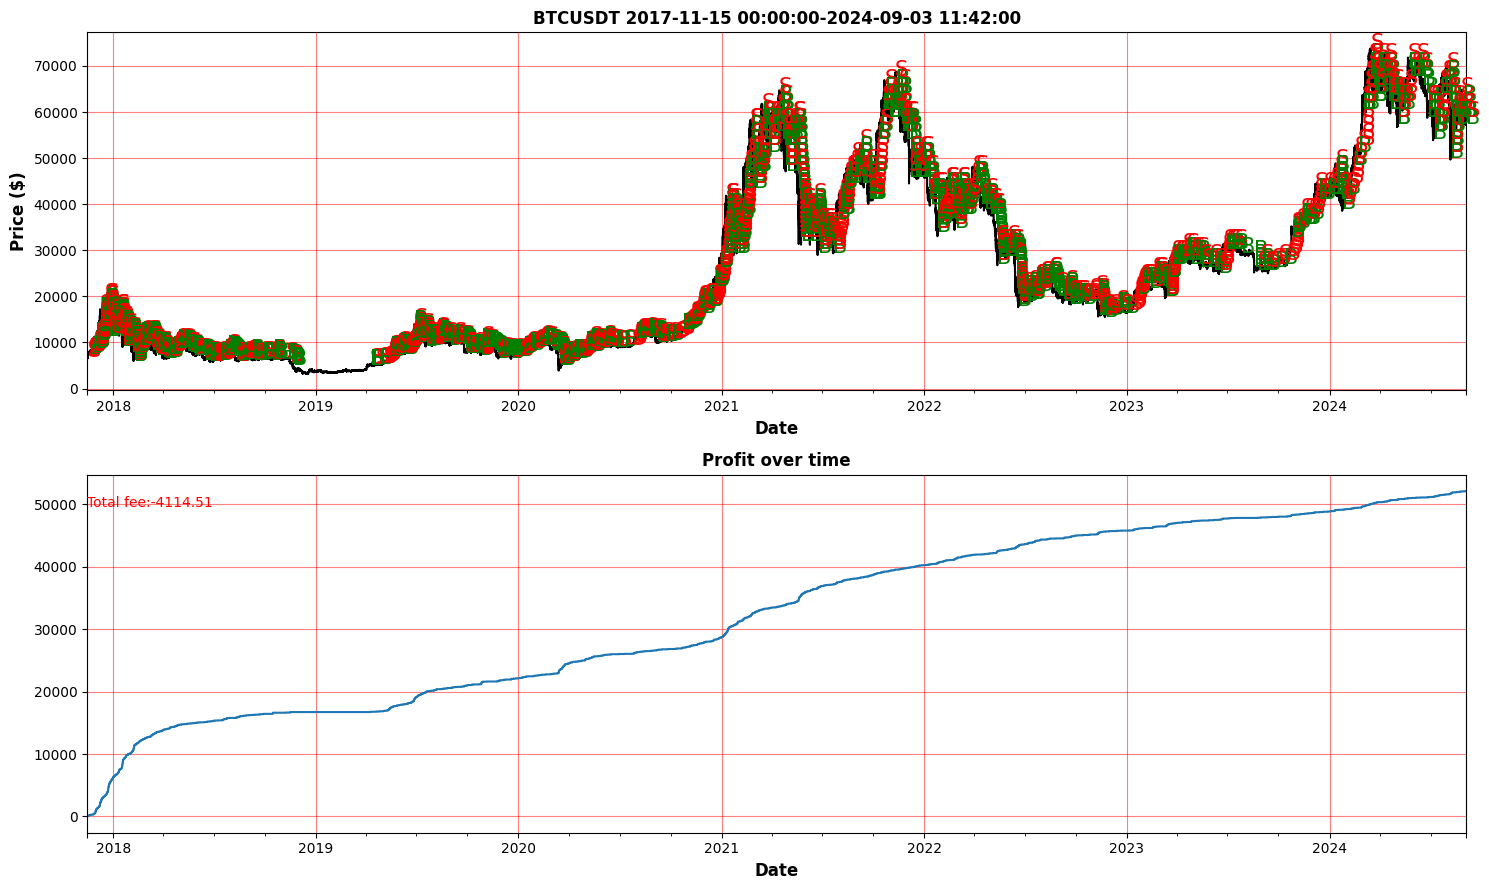

In [6]:
spot.draw()